# Prediciting the Quality of Stackoverflow Questions

## 1. Import Data

In [208]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [142]:
# Define Data Path
DIR = os.getcwd() # current working directory
train_path = "stack_overflow_questions_train.csv"
val_path  = "stack_overflow_questions_valid.csv"

In [143]:
# Load Training Data
TRAIN_PATH = os.path.join(DIR,"data",train_path)
train_df = pd.read_csv(TRAIN_PATH)

train_df.head()

,Id,Title,Body,Tags,CreationDate,Y
0,34552656,Java: Repeat Task Every Random Seconds,<p>I'm already familiar with repeating tasks e...,<java><repeat>,2016-01-01 00:21:59,LQ_CLOSE
1,34553034,Why are Java Optionals immutable?,<p>I'd like to understand why Java 8 Optionals...,<java><optional>,2016-01-01 02:03:20,HQ
2,34553174,Text Overlay Image with Darkened Opacity React...,<p>I am attempting to overlay a title over an ...,<javascript><image><overlay><react-native><opa...,2016-01-01 02:48:24,HQ
3,34553318,Why ternary operator in swift is so picky?,"<p>The question is very simple, but I just cou...",<swift><operators><whitespace><ternary-operato...,2016-01-01 03:30:17,HQ
4,34553755,hide/show fab with scale animation,<p>I'm using custom floatingactionmenu. I need...,<android><material-design><floating-action-but...,2016-01-01 05:21:48,HQ


In [144]:
# Load Test Data
VAL_PATH = os.path.join(DIR,"data",val_path)
val_df = pd.read_csv(VAL_PATH)

val_df.head()

,Id,Title,Body,Tags,CreationDate,Y
0,34552974,How to get all the child records from differen...,I am having 4 different tables like \r\nselect...,<sql><sql-server>,2016-01-01 01:44:52,LQ_EDIT
1,34554721,Retrieve all except some data of the another t...,I have two table m_master and tbl_appointment\...,<php><mysql><sql><codeigniter><mysqli>,2016-01-01 08:43:50,LQ_EDIT
2,34555135,Pandas: read_html,<p>I'm trying to extract US states from wiki U...,<python><pandas>,2016-01-01 09:55:22,HQ
3,34555448,Reader Always gimme NULL,"I'm so new to C#, I wanna make an application ...",<sql-server><c#-4.0>,2016-01-01 10:43:45,LQ_EDIT
4,34555752,php rearrange array elements based on condition,basically i have this array:\r\n\r\n array(...,<php>,2016-01-01 11:34:09,LQ_EDIT


In [145]:
# Print proportion of train and val data
total_data = (train_df.shape[0]+val_df.shape[0])
print(f" Train Data: Count = {train_df.shape[0]}   Percentage of Data = {round(train_df.shape[0]*100/ total_data,2)}")
print(f" Train Data: Count = {val_df.shape[0]}   Percentage of Data = {round(val_df.shape[0]* 100/ total_data, 2)}")

 Train Data: Count = 45000   Percentage of Data = 75.0
 Train Data: Count = 15000   Percentage of Data = 25.0


In [146]:
# Create a combined data frame of train and validation data
combined_df = pd.concat([train_df, val_df])

# Check that data is stacked along rows dimension
assert combined_df.shape[0] == total_data 

## 2. Data Exploration & Preparation

### Cleaning

* Target Distribution

Text(0.5, 0, 'Quality Label')

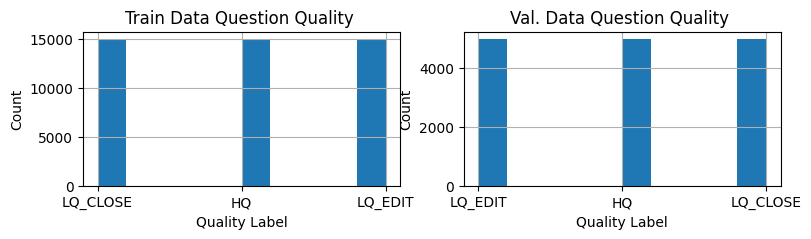

In [147]:
fig, axs = plt.subplots(1,2, figsize=(9, 2))
train_df["Y"].hist(ax=axs[0])
axs[0].set_title(f"Train Data Question Quality ")
axs[0].set_ylabel("Count")
axs[0].set_xlabel("Quality Label")

val_df["Y"].hist(ax=axs[1])
axs[1].set_title(f"Val. Data Question Quality ")
axs[1].set_ylabel("Count")
axs[1].set_xlabel("Quality Label")

* Check for Nulls

In [148]:
# Check data types and nulls
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 60000 entries, 0 to 14999
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Id            60000 non-null  int64 
 1   Title         60000 non-null  object
 2   Body          60000 non-null  object
 3   Tags          60000 non-null  object
 4   CreationDate  60000 non-null  object
 5   Y             60000 non-null  object
dtypes: int64(1), object(5)
memory usage: 3.2+ MB


In [149]:
print("There are records with no text: ", ((combined_df == '').any(axis=1) | (combined_df == ' ').any(axis=1)).any())

There are records with no text:  False


* Convert Body text from XML to string

In [151]:
from bs4 import BeautifulSoup
import re

# Function to remove XML formatting
def convert_text(text):
    # check for xml format
    if text.startswith('<'):
        
        xml = BeautifulSoup(text, "xml")      # parse
        if xml.find():                        # check that text is in xml format
            text = xml.get_text()             # convert from xml  
            
        else:
            html = BeautifulSoup(text, "html")    # parse
            if html.find():
                text = html.get_text()             # convert from html 
                
        text = text.replace('\r', ' ').replace('\n', ' ').strip()   # remove formatting

    return text

# Count paragraphs and change from xml format
dfs = [train_df,val_df] 
for df in dfs:
    # Count paragraphs
    df['Paragraphs'] = df['Body'].apply(lambda x: len(re.findall(r'</p>|(\r\n\s*){2,}', x))) # search for paragraph marker in xml text and or two or more linebreaks

    # Apply the convert_text function to the 'Body' column
    df['Body'] = df['Body'].apply(convert_text)

# View converted text
train_df.head()

,Id,Title,Body,Tags,CreationDate,Y,Paragraphs
0,34552656,Java: Repeat Task Every Random Seconds,I'm already familiar with repeating tasks ever...,<java><repeat>,2016-01-01 00:21:59,LQ_CLOSE,1
1,34553034,Why are Java Optionals immutable?,I'd like to understand why Java 8 Optionals we...,<java><optional>,2016-01-01 02:03:20,HQ,1
2,34553174,Text Overlay Image with Darkened Opacity React...,I am attempting to overlay a title over an ima...,<javascript><image><overlay><react-native><opa...,2016-01-01 02:48:24,HQ,3
3,34553318,Why ternary operator in swift is so picky?,"The question is very simple, but I just could ...",<swift><operators><whitespace><ternary-operato...,2016-01-01 03:30:17,HQ,8
4,34553755,hide/show fab with scale animation,I'm using custom floatingactionmenu. I need to...,<android><material-design><floating-action-but...,2016-01-01 05:21:48,HQ,2


In [139]:
val_df.head()

,Id,Title,Body,Tags,CreationDate,Y,Paragraphs
0,34552974,How to get all the child records from differen...,I am having 4 different tables like \r\nselect...,<sql><sql-server>,2016-01-01 01:44:52,LQ_EDIT,5
1,34554721,Retrieve all except some data of the another t...,I have two table m_master and tbl_appointment\...,<php><mysql><sql><codeigniter><mysqli>,2016-01-01 08:43:50,LQ_EDIT,2
2,34555135,Pandas: read_html,"I'm trying to extract US states from wiki URL,...",<python><pandas>,2016-01-01 09:55:22,HQ,5
3,34555448,Reader Always gimme NULL,"I'm so new to C#, I wanna make an application ...",<sql-server><c#-4.0>,2016-01-01 10:43:45,LQ_EDIT,11
4,34555752,php rearrange array elements based on condition,basically i have this array:\r\n\r\n array(...,<php>,2016-01-01 11:34:09,LQ_EDIT,6


In [158]:
# make sure there are no empty records
for df in dfs:
    assert (df.isna().any() | (df == '').any(axis=1) | (df == ' ').any(axis=1)).any() == False

* Clean & Reformat Features
  

In [159]:
import re
import cleantext
from bs4 import BeautifulSoup
import contractions
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt_tab')

# Clean and reformat data
stop_words = set(stopwords.words('english')) # Define stop words

# For both the test and traing data
for df in dfs:
    
    # Change Creation Date to Year
    df["CreationDate"] = pd.to_datetime(df["CreationDate"]).dt.year
    
    # Remove id columns
    df.drop(["Id"], axis=1,inplace=True) 

    # Handle user mentions
    count_user_mentions = combined_df["Body"].loc[combined_df["Body"].str.contains(r'@\w+')].shape[0]
    df["Body"] = df["Body"].apply(lambda x: re.sub(r'@\w+', '_USER_', x))   # Replace unique user names with @USER
    
    # Replace tag with count of the number of tags
    df["Tags"] = df["Tags"].apply(lambda x: len(re.findall(r'<[^>]+>', x)))
    
    # Clean text columns
    for col in ["Title", "Body"]:
        # Remove contractions
        df[col] = df[col].apply(lambda x:  contractions.fix(x))

        # Clean Words
        df[col] = df[col].apply(lambda x: cleantext.clean( x,
            fix_unicode=True,               # fix various unicode errors
            to_ascii=True,                  # transliterate to closest ASCII representation
            lower=True,                     # lowercase text
            no_line_breaks=True,            # fully strip line breaks as opposed to only normalizing them
            no_urls=True,                   # replace all URLs with a special token
            no_emails=True,                 # replace all email addresses with a special token
            no_phone_numbers=True,          # replace all phone numbers with a special token
            no_numbers=True,                # replace all numbers with a special token
            no_digits=True,                 # replace all digits with a special token
            no_currency_symbols=True,       # replace all currency symbols with a special token
            no_punct=False,                 # remove punctuations
            no_emoji=True,                  # remove emjois
            replace_with_url="_URL_",
            replace_with_email="_EMAIL_",
            replace_with_phone_number="_PHONE_",
            replace_with_number="_NUMBER_",
            replace_with_digit="_NUMBER_",
            replace_with_currency_symbol="_CUR_",
            lang="en"                       # set to english handling
        ))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sian_\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\sian_\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [160]:
train_df.head()

,Title,Body,Tags,CreationDate,Y,Paragraphs
0,java: repeat task every random seconds,i am already familiar with repeating tasks eve...,2,2016,LQ_CLOSE,1
1,why are java optionals immutable?,i would like to understand why java _number_ o...,2,2016,HQ,1
2,text overlay image with darkened opacity react...,i am attempting to overlay a title over an ima...,5,2016,HQ,3
3,why ternary operator in swift is so picky?,"the question is very simple, but i just could ...",5,2016,HQ,8
4,hide/show fab with scale animation,i am using custom floatingactionmenu. i need t...,3,2016,HQ,2


In [161]:
# make sure there are no empty records
for df in dfs:
    assert (df.isna().any() | (df == '').any(axis=1) | (df == ' ').any(axis=1)).any() == False

* Tokenization & removal of stop words

In [163]:
# Funtion to tokenize words and remore stop words
def tokenize(text):
    tokens = [w for w in word_tokenize(text) if w.lower() not in stop_words] # Tokenize and remove stopwords
    
    # Check for punctuation within words
    cleaned_tokens = []
    for token in tokens:
        split_words = re.split(r"[/.\\-^]", token) 
        cleaned_tokens.extend([w for w in split_words if w.isalpha()])  #remove punctuation

    return cleaned_tokens

# Apply tokenization with stop word removal
for df in dfs:
    for col in ["Title", "Body"]:
        df[col] = df[col].apply(tokenize)

In [164]:
train_df.head()

,Title,Body,Tags,CreationDate,Y,Paragraphs
0,"[java, repeat, task, every, random, seconds]","[already, familiar, repeating, tasks, every, n...",2,2016,LQ_CLOSE,1
1,"[java, optionals, immutable]","[would, like, understand, java, optionals, des...",2,2016,HQ,1
2,"[text, overlay, image, darkened, opacity, reac...","[attempting, overlay, title, image, image, dar...",5,2016,HQ,3
3,"[ternary, operator, swift, picky]","[question, simple, could, find, answer]",5,2016,HQ,8
4,"[hide, show, fab, scale, animation]","[using, custom, floatingactionmenu, need, impl...",3,2016,HQ,2


In [167]:
# make sure there are no empty records
for df in dfs:
    assert (df.isna().any() | (df == '').any(axis=1) | (df == ' ').any(axis=1)).any() == False

In [ ]:
# Handle spelling mistakes -- SKIP TOO TIME CONSUMING
# from textblob import TextBlob

# # For both the test and traing data
# for df in dfs:
#     for col in ["Title", "Body"]:
#         df[col] = df[col].apply(lambda x:  ''.join(TextBlob(x).correct()))

* Lemmatization

In [168]:
import spacy
nlp = spacy.load('en_core_web_sm')

for df in dfs:
    for col in ["Title", "Body"]:
        df[col] = df[col].apply(lambda x:  " ".join([token.lemma_ for token in nlp(str(x))]))
        
train_df.head()

,Title,Body,Tags,CreationDate,Y,Paragraphs
0,"[ ' java ' , ' repeat ' , ' task ' , ' every '...","[ ' already ' , ' familiar ' , ' repeat ' , ' ...",2,2016,LQ_CLOSE,1
1,"[ ' java ' , ' optional ' , ' immutable ' ]","[ ' would ' , ' like ' , ' understand ' , ' ja...",2,2016,HQ,1
2,"[ ' text ' , ' overlay ' , ' image ' , ' darke...","[ ' attempt ' , ' overlay ' , ' title ' , ' im...",5,2016,HQ,3
3,"[ ' ternary ' , ' operator ' , ' swift ' , ' p...","[ ' question ' , ' simple ' , ' could ' , ' fi...",5,2016,HQ,8
4,"[ ' hide ' , ' show ' , ' fab ' , ' scale ' , ...","[ ' use ' , ' custom ' , ' floatingactionmenu ...",3,2016,HQ,2


In [169]:
# make sure there are no empty records
for df in dfs:
    assert (df.isna().any() | (df == '').any(axis=1) | (df == ' ').any(axis=1)).any() == False

In [170]:
store_df = pd.concat([train_df,val_df])

In [ ]:
# train_df = store_df.iloc[:train_df.shape[0], :].copy()
# val_df = store_df.iloc[train_df.shape[0]:, :].copy()

* Count Number of unique Words in Body

In [44]:
combined_df = pd.concat([train_df, val_df])

for col in ["Title", "Body"]:
    lemmatized_tokens = []
    for doc in combined_df[col]:
        doc = re.sub(r"[',\[\]]", "", doc)      # remove string formatting
        lemmatized_tokens.extend(doc.split())   # split string into words

    # Get unique lemmas
    vocabulary_size = len(set(lemmatized_tokens))
    print(f"{col} - vocabulary size is {vocabulary_size}")

Title - vocabulary size is 17291
Body - vocabulary size is 72320


### Feature Engineering

* Title: Add extra features

  1. Number of words in both Title and Body
  2. Number of unique words in Title

In [171]:
for df in [train_df, val_df]:
    # Add feature:  number of intersecting words in Title and Body
    df["Title_Overlap"] = df.apply(lambda row: len(
        set( re.sub(r"[',\[\]]", "", str(row["Title"])).split()) & set( re.sub(r"[',\[\]]", "", str(row["Body"])).split())), axis=1)
    
    # Add feature:  number of unique words in Title 
    df["Title_Word"] = df["Title"].apply(lambda x: len(( re.sub(r"[',\[\]]", "", x).split())) )
    
train_df.head()

,Title,Body,Tags,CreationDate,Y,Paragraphs,Title_Overlap,Title_Word
0,"[ ' java ' , ' repeat ' , ' task ' , ' every '...","[ ' already ' , ' familiar ' , ' repeat ' , ' ...",2,2016,LQ_CLOSE,1,6,6
1,"[ ' java ' , ' optional ' , ' immutable ' ]","[ ' would ' , ' like ' , ' understand ' , ' ja...",2,2016,HQ,1,3,3
2,"[ ' text ' , ' overlay ' , ' image ' , ' darke...","[ ' attempt ' , ' overlay ' , ' title ' , ' im...",5,2016,HQ,3,5,7
3,"[ ' ternary ' , ' operator ' , ' swift ' , ' p...","[ ' question ' , ' simple ' , ' could ' , ' fi...",5,2016,HQ,8,0,4
4,"[ ' hide ' , ' show ' , ' fab ' , ' scale ' , ...","[ ' use ' , ' custom ' , ' floatingactionmenu ...",3,2016,HQ,2,4,5


* Body: Add new features

    1. Subjectivity on a scale of objective (0) to subjetcive (1). This helps to determine the amount of facts vs personal views included, and can give an indication of well defined questions.
    2. Polarity on a sclae of negative (-1) to positive (1). This give insights into the tone of the question.
    3. Number of unique words in Body

In [172]:
from textblob import TextBlob

# Function to get subjectivity and polarity of the text
def get_sentiment(text):
        blob = TextBlob(text)
        polarity = blob.sentiment.polarity
        subjectivity = blob.sentiment.subjectivity
        return pd.Series([polarity, subjectivity])

# Add subjectivity and polarity of "Body" to dataframe 
for df in [train_df, val_df]:
    df[["Body_Pol", "Body_Subj"]] = df["Body"].apply(lambda x: get_sentiment(x))
    df["Body_Word"] = df["Body"].apply(lambda x: len(( re.sub(r"[',\[\]]", "", x).split())) )
    
train_df.head()

,Title,Body,Tags,CreationDate,Y,Paragraphs,Title_Overlap,Title_Word,Body_Pol,Body_Subj,Body_Word
0,"[ ' java ' , ' repeat ' , ' task ' , ' every '...","[ ' already ' , ' familiar ' , ' repeat ' , ' ...",2,2016,LQ_CLOSE,1,6,6,-0.0875,0.500000,34
1,"[ ' java ' , ' optional ' , ' immutable ' ]","[ ' would ' , ' like ' , ' understand ' , ' ja...",2,2016,HQ,1,3,3,0.0000,0.000000,7
2,"[ ' text ' , ' overlay ' , ' image ' , ' darke...","[ ' attempt ' , ' overlay ' , ' title ' , ' im...",5,2016,HQ,3,5,7,0.0500,0.400000,20
3,"[ ' ternary ' , ' operator ' , ' swift ' , ' p...","[ ' question ' , ' simple ' , ' could ' , ' fi...",5,2016,HQ,8,0,4,0.0000,0.357143,5
4,"[ ' hide ' , ' show ' , ' fab ' , ' scale ' , ...","[ ' use ' , ' custom ' , ' floatingactionmenu ...",3,2016,HQ,2,4,5,0.1000,0.100000,16


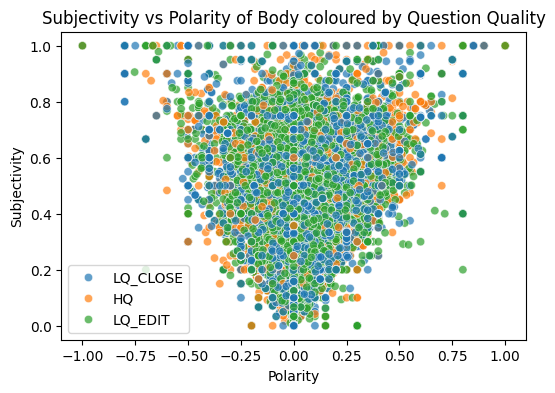

In [47]:
# View Polarity and Subjectivity
plt.figure(figsize=(6, 4))
sns.scatterplot(data=train_df, x="Body_Pol", y="Body_Subj", hue="Y", alpha=0.7) # make slighty transparent to see density of points better
plt.title("Subjectivity vs Polarity of Body coloured by Question Quality")
plt.xlabel("Polarity")
plt.ylabel("Subjectivity")
plt.legend()
plt.show()


* Body: Embed with CountVectorizer (computationally efficient)

    The vocabulary was very large which would be time consuming even with the cmputationally efficient embedder so this step was omitted and numeric features will be focused on

* Generate Word Cloud

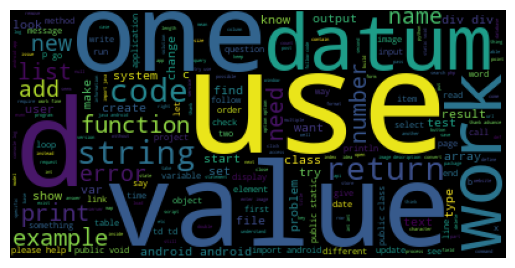

In [48]:
from wordcloud import WordCloud

# Generate word cloud of  "Body"
cloud = WordCloud() 
cloud = cloud.generate(" ".join(train_df["Body"].astype(str).tolist()))

# Plot word cloud
plt.imshow(cloud)
plt.axis('off')  
plt.show()

* View histogram of data

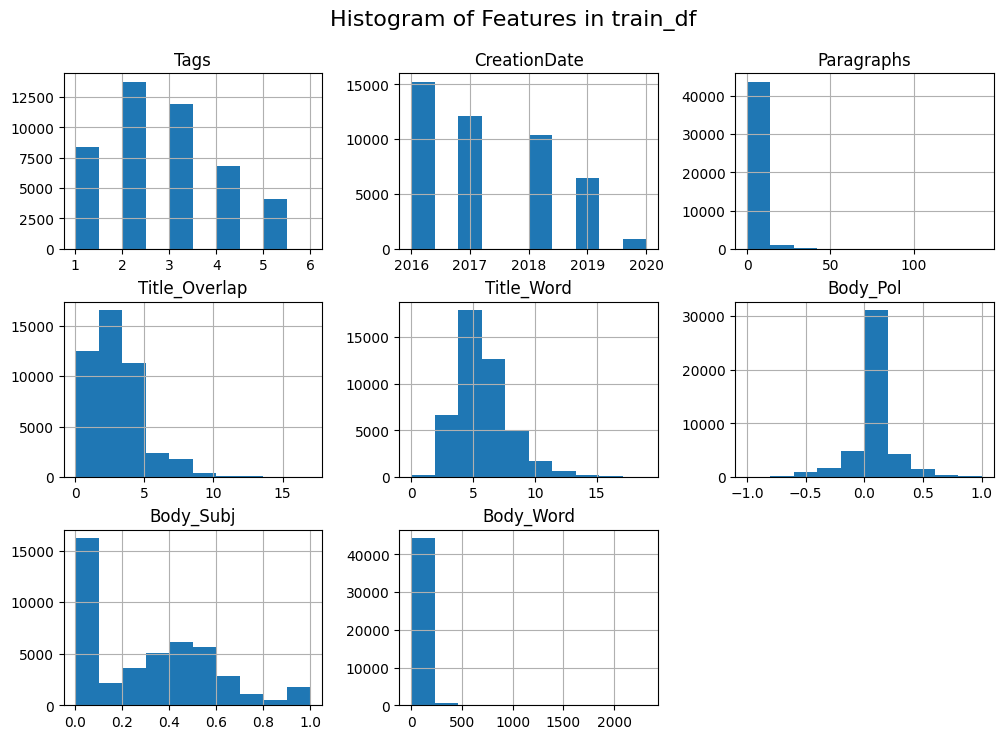

In [178]:
train_df.hist(figsize=(12, 8))
plt.suptitle("Histogram of Features in train_df", fontsize=16)
plt.subplots_adjust(top=0.9)  # Adjust title to fit
plt.xlabel("Feature Value", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.show()

Take away:
    Features do not follow a normal distribution. This will impact choice of fetaure scaling method and correlation metrics.

* View how features impact target

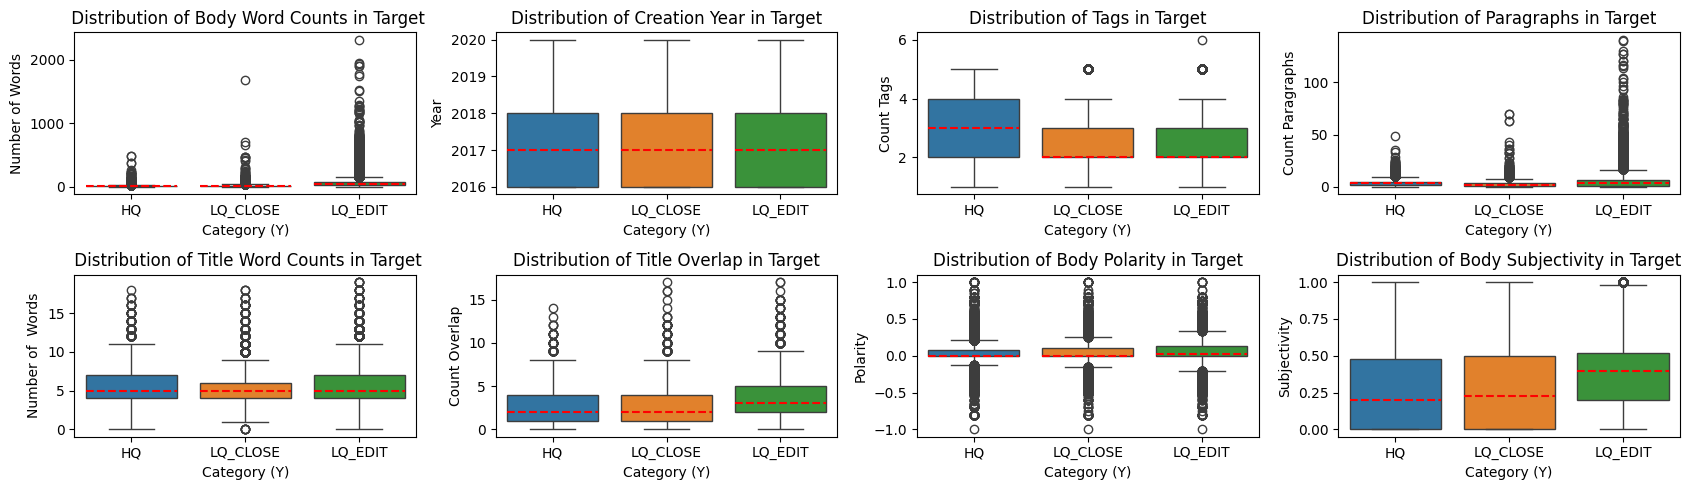

In [180]:
# Create Figure
fig, axs = plt.subplots(2, 4, figsize=(17,5))
axs = axs.flatten()

# Sort Data By Target
train_df = train_df.sort_values(by='Y', ascending=True)

# Plot Body Words
sns.boxplot(data=train_df, x="Y", y="Body_Word", hue="Y", ax=axs[0], medianprops=dict(color="red", linewidth=1.5, linestyle='--'))
axs[0].set_title(f" Distribution of Body Word Counts in Target")
axs[0].set_ylabel("Number of Words")
axs[0].set_xlabel("Category (Y)")

# Plot Year
sns.boxplot(data=train_df, x="Y", y="CreationDate", hue="Y", ax=axs[1], medianprops=dict(color="red", linewidth=1.5, linestyle='--'))
axs[1].set_title(f"Distribution of Creation Year in Target")
axs[1].set_ylabel("Year")
axs[1].set_xlabel("Category (Y)")

# Plot Tags
sns.boxplot(data=train_df, x="Y", y="Tags", hue="Y", ax=axs[2], medianprops=dict(color="red", linewidth=1.5,linestyle='--'))
axs[2].set_title(f"Distribution of Tags in Target")
axs[2].set_ylabel("Count Tags")
axs[2].set_xlabel("Category (Y)")

# Plot Paragraphs
sns.boxplot(data=train_df, x="Y", y="Paragraphs", hue="Y", ax=axs[3], medianprops=dict(color="red", linewidth=1.5,linestyle='--'))
axs[3].set_title(f"Distribution of Paragraphs in Target")
axs[3].set_ylabel("Count Paragraphs")
axs[3].set_xlabel("Category (Y)")

# Plot Title Words
i = 4
sns.boxplot(data=train_df, x="Y", y="Title_Word", hue="Y", ax=axs[i], medianprops=dict(color="red", linewidth=1.5, linestyle='--'))
axs[i].set_title(f" Distribution of Title Word Counts in Target")
axs[i].set_ylabel("Number of  Words")
axs[i].set_xlabel("Category (Y)")

# Plot Title Overlap
i += 1
sns.boxplot(data=train_df, x="Y", y="Title_Overlap", hue="Y", ax=axs[i], medianprops=dict(color="red", linewidth=1.5, linestyle='--'))
axs[i].set_title(f"Distribution of Title Overlap in Target")
axs[i].set_ylabel("Count Overlap")
axs[i].set_xlabel("Category (Y)")

# Plot Pol.
i += 1
sns.boxplot(data=train_df, x="Y", y="Body_Pol", hue="Y", ax=axs[i], medianprops=dict(color="red", linewidth=1.5,linestyle='--'))
axs[i].set_title(f"Distribution of Body Polarity in Target")
axs[i].set_ylabel("Polarity")
axs[i].set_xlabel("Category (Y)")

# Plot Subj
i += 1
sns.boxplot(data=train_df, x="Y", y="Body_Subj", hue="Y", ax=axs[i], medianprops=dict(color="red", linewidth=1.5,linestyle='--'))
axs[i].set_title(f"Distribution of Body Subjectivity in Target")
axs[i].set_ylabel("Subjectivity")
axs[i].set_xlabel("Category (Y)")

plt.tight_layout()
plt.show()

Remarks,
1. Takeaways:
   * LQ_EDIT can be identified by higher scores in Body_Words, Paragraphs, Title Overlap, Subjectivity and lower score in Tags
   * HQ can be identified by higher scores in Tags and lower scores in Body Words, Title Overlap, Subjectivity
   * LQ_CLOSE can be identified by lower scores in Tags, Paragraphs and Subjectivity


* Encode the Target Variable

In [181]:
# Print unique target variables
train_df["Y"].unique()

array(['HQ', 'LQ_CLOSE', 'LQ_EDIT'], dtype=object)

In [240]:
# Encode quality on a scale LQ_Close -> LQ_Edit -> HQ
target_mapping = {'LQ_CLOSE':0, 'LQ_EDIT':1, 'HQ':2} #set ordering

for df in [train_df, val_df]:
    df["Y_enc"] = df["Y"].replace(target_mapping)


In [242]:
train_df.head()

,Title,Body,Tags,CreationDate,Y,Paragraphs,Title_Overlap,Title_Word,Body_Pol,Body_Subj,Body_Word,Y_enc
22972,"[ ' get ' , ' complete ' , ' topic ' , ' distr...","[ ' train ' , ' lda ' , ' model ' ]",3,2017,HQ,6,1,8,0.0,0.0,3,2
22559,"[ ' possible ' , ' copy ' , ' code ' , ' one '...","[ ' currently ' , ' work ' , ' build ' , ' dep...",3,2017,HQ,5,3,11,0.0,0.4,7,2
810,"[ ' inhibit ' , ' warning ' , ' option ' , ' x...","[ ' cocoapod ' , ' set ' , ' pod ' , ' project...",4,2016,HQ,4,6,8,0.0,0.4,21,2
23334,"[ ' middleware ' , ' one ' , ' specific ' , ' ...","[ ' middleware ' , ' auth ' , ' app ' , ' http...",2,2017,HQ,12,1,6,0.0,0.0,5,2
812,"[ ' forbid ' , ' use ' , ' remote ' , ' functi...","[ ' use ' , ' string ' , ' module ' , ' guard ' ]",1,2016,HQ,3,2,6,0.0,0.0,4,2


* View Pair Plots to see interactions and distributions

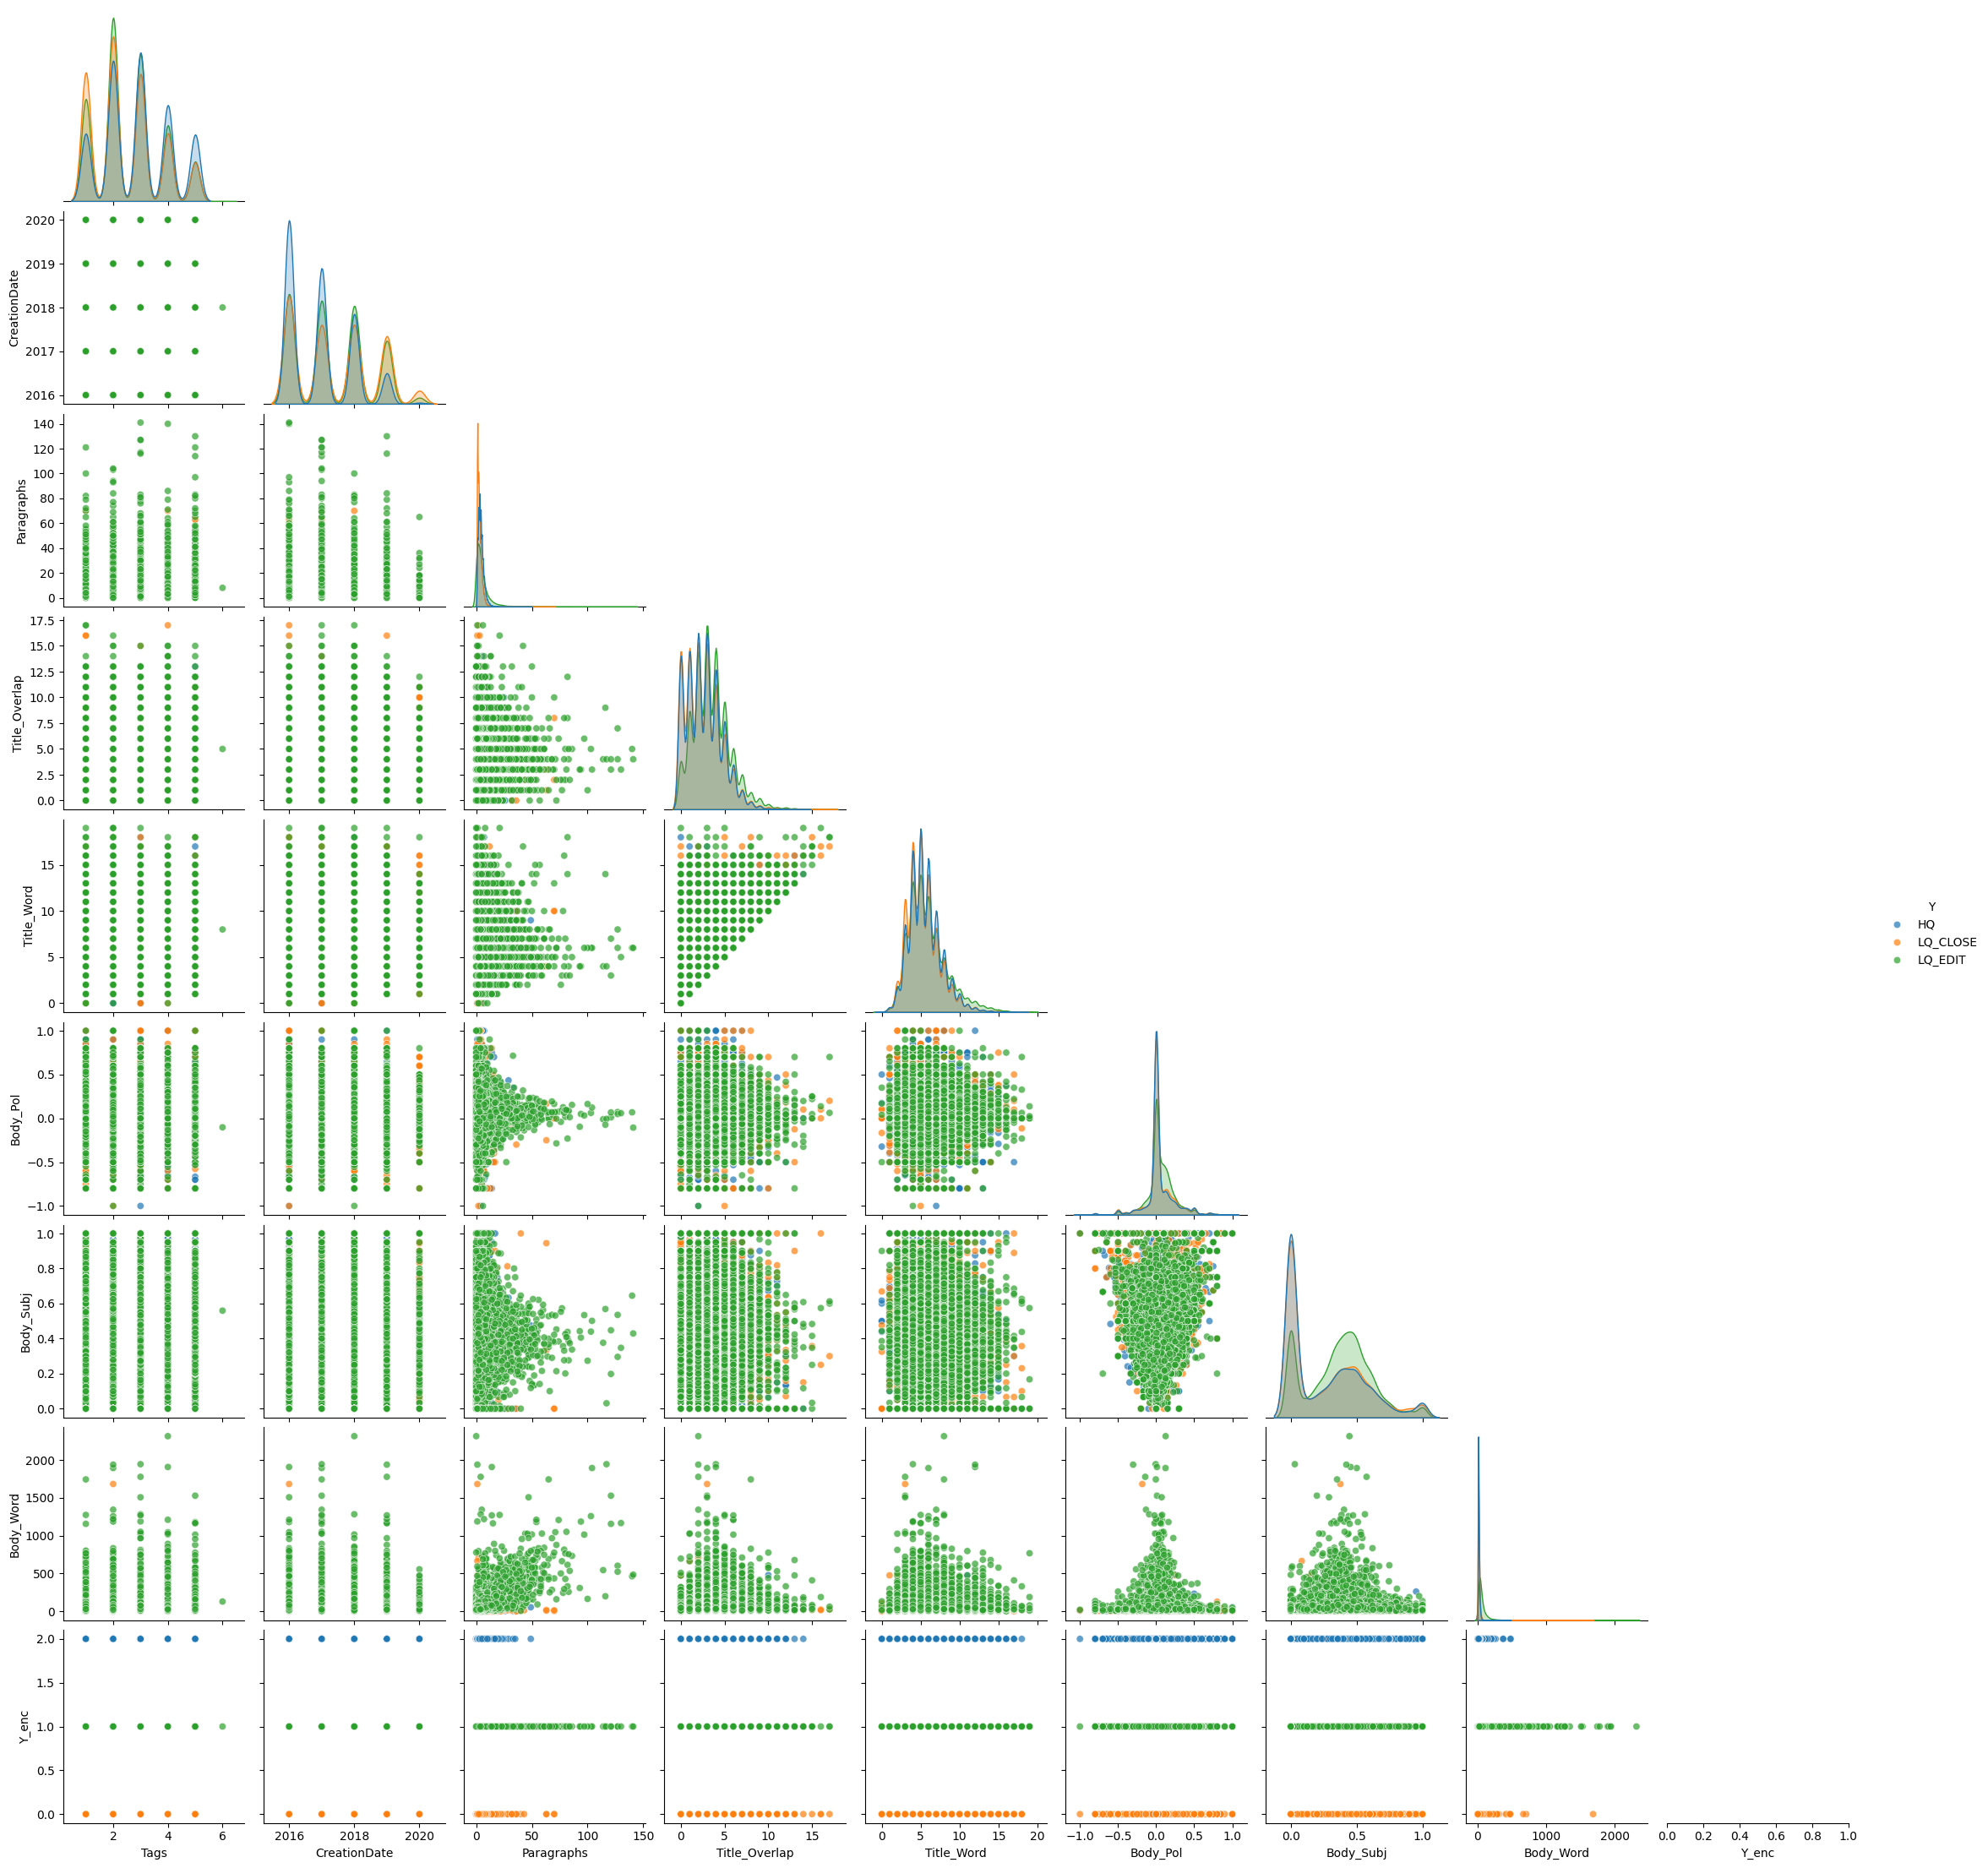

In [243]:
sns.pairplot(train_df, hue='Y', palette="tab10", plot_kws={'alpha': 0.7}, corner=True)
plt.show()

Remarks,
1. No clear trends seen

## 2. Data Preparation

Text(0.5, 0, 'Quality Label')

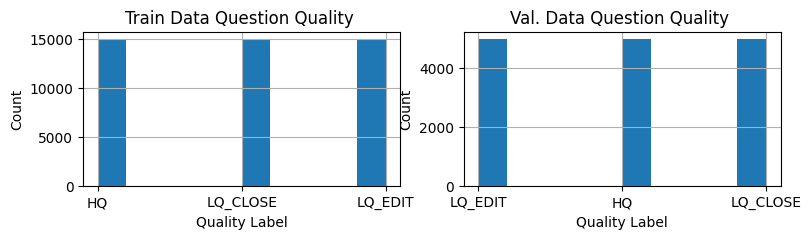

In [347]:
# View target distribution after cleaning
fig, axs = plt.subplots(1,2, figsize=(9, 2))
train_df["Y"].hist(ax=axs[0])
axs[0].set_title(f"Train Data Question Quality ")
axs[0].set_ylabel("Count")
axs[0].set_xlabel("Quality Label")

val_df["Y"].hist(ax=axs[1])
axs[1].set_title(f"Val. Data Question Quality ")
axs[1].set_ylabel("Count")
axs[1].set_xlabel("Quality Label")

In [245]:
# View data
train_df.describe()

,Tags,CreationDate,Paragraphs,Title_Overlap,Title_Word,Body_Pol,Body_Subj,Body_Word,Y_enc
count,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000
mean,2.653889,2017.235044,4.201844,2.905311,5.590533,0.045176,0.301782,33.182667,1.000000
std,1.204084,1.121529,5.353064,2.084919,2.259097,0.186079,0.278823,67.761239,0.816506
min,1.000000,2016.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000
25%,2.000000,2016.000000,2.000000,1.000000,4.000000,0.000000,0.000000,9.000000,0.000000
50%,3.000000,2017.000000,3.000000,3.000000,5.000000,0.000000,0.314268,17.000000,1.000000
75%,3.000000,2018.000000,5.000000,4.000000,7.000000,0.115000,0.500000,32.000000,2.000000
max,6.000000,2020.000000,141.000000,17.000000,19.000000,1.000000,1.000000,2314.000000,2.000000


* Apply Scaler

In [352]:
T_df = train_df.drop(["Title","Body"], axis=1)
V_df = val_df.drop(["Title","Body"], axis=1)

In [354]:
# Scale Data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

columns = T_df.drop(["Y","Y_enc"], axis=1).columns  

# Fit on training data and transform both train & validation sets
T_df[columns] = scaler.fit_transform(T_df[columns])
V_df[columns] = scaler.transform(V_df[columns]) 

T_df.describe()

,Tags,CreationDate,Paragraphs,Title_Overlap,Title_Word,Body_Pol,Body_Subj,Body_Word,Y_enc
count,4.500000e+04,4.500000e+04,4.500000e+04,45000.000000,4.500000e+04,4.500000e+04,4.500000e+04,4.500000e+04,45000.000000
mean,-3.410605e-17,-9.094947e-17,1.010550e-17,0.000000,2.526374e-17,-1.515825e-17,-1.515825e-17,1.010550e-17,1.000000
std,1.000011e+00,1.000011e+00,1.000011e+00,1.000011,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,0.816506
min,-1.373582e+00,-1.101227e+00,-7.849506e-01,-1.393504,-2.474704e+00,-5.616902e+00,-1.082356e+00,-4.897053e-01,0.000000
25%,-5.430655e-01,-1.101227e+00,-4.113287e-01,-0.913864,-7.040651e-01,-2.427795e-01,-1.082356e+00,-3.568845e-01,0.000000
50%,2.874510e-01,-2.095774e-01,-2.245177e-01,0.045417,-2.614053e-01,-2.427795e-01,4.478133e-02,-2.388216e-01,1.000000
75%,2.874510e-01,6.820727e-01,1.491042e-01,0.525057,6.239142e-01,3.752446e-01,7.109162e-01,-1.745363e-02,2.000000
max,2.779000e+00,2.465373e+00,2.555540e+01,6.760381,5.935831e+00,5.131343e+00,2.504189e+00,3.365999e+01,2.000000


* Compute Rank Correlation using Kendall's Tau
  * for ordinal and continuous
  * no assumptions about underlying data distribution

In [355]:
from scipy import stats

# Function to compute Kendall's Tau Correlation 
def plot_kendall_matrix(df_clean, kendall_cols, alpha, target):
    kendalls_corr = pd.DataFrame(index=kendall_cols, columns=kendall_cols)          # to store corr
    significance_matrix = pd.DataFrame(index=kendall_cols, columns=kendall_cols)    # to store p_value

    for col1 in kendall_cols:
        for col2 in kendall_cols:
            tau, p_value = stats.kendalltau(df_clean[col1], df_clean[col2])
            kendalls_corr.loc[col1, col2] = tau
            significance_matrix.loc[col1, col2] = p_value

    # Plot correlation as heatmap
    plt.imshow(kendalls_corr.astype(float), vmin=-1, vmax=1, cmap='viridis')
    plt.colorbar()
    plt.xticks(range(len(kendall_cols)),labels=kendall_cols, rotation=90)
    plt.yticks(range(len(kendall_cols)),labels=kendall_cols, rotation=0)
    plt.title("Correlation for Continuous & Ordinal Features with significance flag (Kendall's Tau)")

    # Overlay the significance of correlation as text
    to_drop = []
    for i,col1 in enumerate(kendall_cols):
        for j,col2 in enumerate(kendall_cols):
            sig = significance_matrix.loc[col1, col2] # get significance
        
            # Annotate the significance text in the heatmap
            if sig <= alpha/2: # divide alpha by two since a two tail test was used
                plt.text(j, i, "T", ha='center', va='center', color='white', fontsize=10)
            else:
                plt.text(j, i, "F", ha='center', va='center', color='red', fontsize=10)
                if col1 == target:
                    to_drop +=[col2]

    # show plot
    plt.show()
    print("Features to remove: ", to_drop)

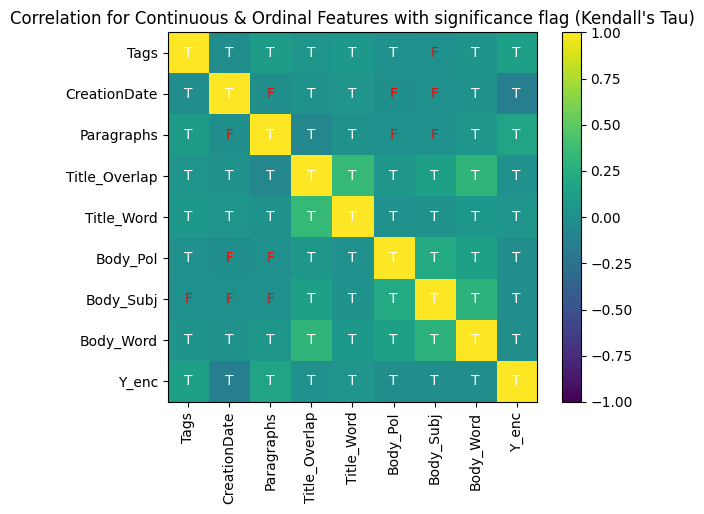

Features to remove:  []


In [356]:
# Plot Kendalls Tau Matrix
cols = [col for col in T_df.columns.tolist() if col != 'Y']
plot_kendall_matrix(T_df, cols, alpha=0.05, target='Y')

Remarks, 
* Features show moderate but significant relationship with target


  ## 2. Predictive Models

In [410]:
import torch
from torch import nn
from torch import einsum
from einops import rearrange, repeat
from einops.layers.torch import Rearrange
import torch
import torch.nn.functional as F
from torch import optim

def pair(t):
    return t if isinstance(t, tuple) else (t, t)

# classes
class Log_softmax(nn.Module):
    def __init__(self, dim=-1):
        super().__init__()
        self.dim = dim
    def forward(self, x):
        x_max = torch.max(x)
        return x - x_max - torch.log(torch.sum(torch.exp(x - x_max), dim=self.dim)).unsqueeze(-1)

class PreNorm(nn.Module):
    def __init__(self, dim, fn, eps):
        super().__init__()
        self.norm = nn.LayerNorm(dim, eps=eps)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.ReLU(), 
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads = 4, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = Log_softmax(dim=-1)
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = h), qkv)

        dots = einsum('b h i d, b h j d -> b h i j', q, k) * self.scale

        attn = self.attend(dots)

        out = einsum('b h i j, b h j d -> b h i d', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0., eps=1e-5):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout), eps),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout), eps)
            ]))
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x

class transformer_model(nn.Module):
    def __init__(self, *, input_dim, num_classes, dim, depth, heads, mlp_dim, pool = 'cls', dim_head = 64, dropout = 0.05, emb_dropout = 0.05, eps=1e-5):
        super().__init__()

        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.embed = nn.Linear(input_dim, dim)
        self.dropout = nn.Dropout(emb_dropout)
        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout, eps)
        self.pool = pool
        self.to_latent = nn.Identity()
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim, eps),
            nn.Linear(dim, num_classes)
        )

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.embed(x)
        b, n, _ = x.shape
        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x = self.dropout(x)
        x = self.transformer(x)
        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]
        x = self.to_latent(x)
        return self.mlp_head(x)
    
    
def train_epoch(model, optimizer, data_loader, loss_history, accuracy_history):
    total_samples = len(data_loader.dataset)
    model.train()

    correct_samples = 0
    total_loss = 0

    for i, (data, target) in enumerate(data_loader):
        optimizer.zero_grad()
        output = F.log_softmax(model(data), dim=1)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        # Accuracy computation
        _, pred = torch.max(output, dim=1)
        correct_samples += pred.eq(target).sum().item()
        total_loss += loss.item()

        # if i % 100 == 0:
            # print('[' +  '{:5}'.format(i * len(data)) + '/' + '{:5}'.format(total_samples) +
            #     ' (' + '{:3.0f}'.format(100 * i / len(data_loader)) + '%)]  Loss: ' +
            #     '{:6.4f}'.format(loss.item()))
            

    avg_loss = total_loss / total_samples
    accuracy = 100.0 * correct_samples / total_samples
    accuracy_history.append(accuracy)
    loss_history.append(avg_loss)
    print(f'Avg Train Loss: {avg_loss:.4f}  Train Accuracy: {accuracy:.2f}%')
    
    return  loss_history, accuracy_history

def evaluate(model, data_loader, loss_history, accuracy_history):
    model.eval()

    total_samples = len(data_loader.dataset)
    correct_samples = 0
    total_loss = 0

    with torch.no_grad():
        for data, target in data_loader:
            output = F.log_softmax(model(data), dim=1)
            loss = F.nll_loss(output, target, reduction='sum')
            _, pred = torch.max(output, dim=1)

            total_loss += loss.item()
            correct_samples += pred.eq(target).sum().item()

    avg_loss = total_loss / total_samples
    accuracy = 100.0 * correct_samples / total_samples
    loss_history.append(avg_loss)
    accuracy_history.append(accuracy)

    print('Avg Test loss: {:.4f}   Test Accuracy: {:.2f}%\n'.format(avg_loss, accuracy))
    return avg_loss, accuracy, loss_history, accuracy_history

* Define Transformer

In [411]:
#from helpers.tnn import transformer_model
from torchinfo import summary
import torch

# Encoder only transformer
torch.manual_seed(2)
device = torch.device( "cpu")

# Define training params
BATCH_SIZE_TRAIN = 64
BATCH_SIZE_TEST = 64
N_EPOCHS = 20
num_classes=T_df['Y'].nunique()  # target classes
input_dim = int(len(T_df.columns)-2)

# Hyper params
dim = 24
depth =4
heads = 6
dim_head = int(dim/heads)
mlp_dim = 128
dropout = 0
emb_dropout = 0

# Define TNN
tnn_model = transformer_model(input_dim=input_dim,
        num_classes=num_classes,
        dim=dim,
        depth=depth,
        heads=heads,
        mlp_dim=mlp_dim,
        pool='cls',
        dim_head=dim_head,
        dropout=dropout,
        emb_dropout=emb_dropout,
        eps=1e-5
    )

# Print model summary
summary(tnn_model)

Layer (type:depth-idx)                             Param #
transformer_model                                  24
├─Linear: 1-1                                      216
├─Dropout: 1-2                                     --
├─Transformer: 1-3                                 --
│    └─ModuleList: 2-1                             --
│    │    └─ModuleList: 3-1                        8,720
│    │    └─ModuleList: 3-2                        8,720
│    │    └─ModuleList: 3-3                        8,720
│    │    └─ModuleList: 3-4                        8,720
├─Identity: 1-4                                    --
├─Sequential: 1-5                                  --
│    └─LayerNorm: 2-2                              48
│    └─Linear: 2-3                                 75
Total params: 35,243
Trainable params: 35,243
Non-trainable params: 0

In [412]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# Define Test and Train Sets
x = torch.from_numpy(T_df.drop(["Y", "Y_enc"], axis=1).values.astype(np.float32))
y = torch.from_numpy(T_df["Y_enc"].values)
train_set = TensorDataset(x, y.long())
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE_TRAIN, shuffle=True)


x = torch.from_numpy(V_df.drop(["Y", "Y_enc"], axis=1).values.astype(np.float32))
y = torch.from_numpy(V_df["Y_enc"].values)
test_set = TensorDataset(x, y.long())
test_loader = DataLoader(train_set, batch_size=BATCH_SIZE_TRAIN, shuffle=False)


Epoch: 1
Avg Train Loss: 0.0125  Train Accuracy: 61.37%
Avg Test loss: 0.7668   Test Accuracy: 62.70%

Epoch: 2
Avg Train Loss: 0.0115  Train Accuracy: 65.36%
Avg Test loss: 0.7085   Test Accuracy: 67.02%

Epoch: 3
Avg Train Loss: 0.0112  Train Accuracy: 66.26%
Avg Test loss: 0.7157   Test Accuracy: 66.52%

Epoch: 4
Avg Train Loss: 0.0111  Train Accuracy: 66.57%
Avg Test loss: 0.7033   Test Accuracy: 67.10%

Epoch: 5
Avg Train Loss: 0.0111  Train Accuracy: 66.68%
Avg Test loss: 0.7011   Test Accuracy: 67.10%

Epoch: 6
Avg Train Loss: 0.0110  Train Accuracy: 66.94%
Avg Test loss: 0.7094   Test Accuracy: 66.41%

Epoch: 7
Avg Train Loss: 0.0111  Train Accuracy: 66.89%
Avg Test loss: 0.7108   Test Accuracy: 66.62%

Epoch: 8
Avg Train Loss: 0.0110  Train Accuracy: 66.88%
Avg Test loss: 0.7004   Test Accuracy: 67.44%

Epoch: 9
Avg Train Loss: 0.0110  Train Accuracy: 66.96%
Avg Test loss: 0.7023   Test Accuracy: 67.13%

Epoch: 10
Avg Train Loss: 0.0110  Train Accuracy: 67.00%
Avg Test loss: 0

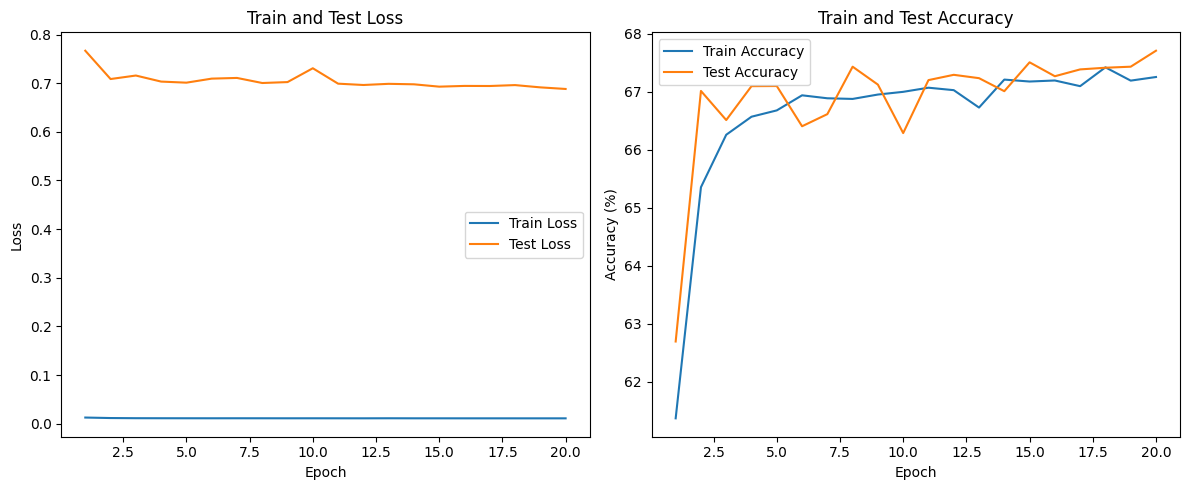

Avg Test loss: 0.6881   Test Accuracy: 67.71%

Final Test Accuracy: 67.71%


In [413]:
import torch.nn.functional as F
from torch import optim
#from helpers.tnn import train_epoch, evaluate


optimizer = optim.Adam(tnn_model.parameters(), lr=2e-3)

# Initialize history lists for loss and accuracy
train_loss_history, test_loss_history = [], []
train_accuracy_history, test_accuracy_history = [], []


for epoch in range(1, N_EPOCHS + 1):
    print('Epoch:', epoch)
    train_loss_history, train_accuracy_history = train_epoch(tnn_model, optimizer, train_loader, train_loss_history, train_accuracy_history)
    avg_test_loss, test_accuracy, test_loss_history, test_accuracy_history= evaluate(tnn_model, test_loader, test_loss_history, test_accuracy_history)
    
# Save the model
name = f"stackoverflow_quality"
torch.save(tnn_model, f"results/question_quality/{name}.pt")

# Plotting
plt.figure(figsize=(12, 5))

# Plot Train Loss and Test Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, N_EPOCHS + 1), train_loss_history, label='Train Loss')
plt.plot(range(1, N_EPOCHS + 1), test_loss_history, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Train and Test Loss')

# Plot Train Accuracy and Test Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, N_EPOCHS + 1), train_accuracy_history, label='Train Accuracy')
plt.plot(range(1, N_EPOCHS + 1), test_accuracy_history, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Train and Test Accuracy')

plt.tight_layout()
plt.show()

# Final test accuracy
avg_test_loss, test_accuracy, _, _ = evaluate(tnn_model, test_loader, test_loss_history, test_accuracy_history)
print(f"Final Test Accuracy: {test_accuracy:.2f}%")
